In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [8]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


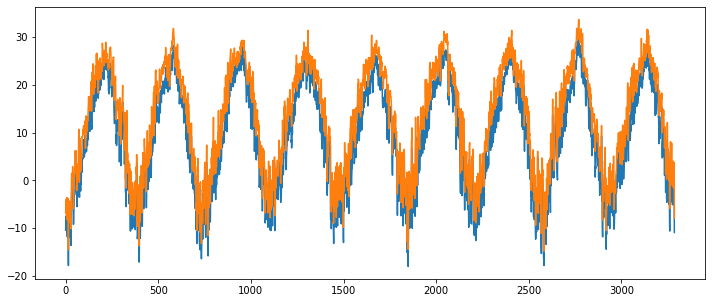

In [9]:
min_data = temp[['min']]
temp_data = temp[['avg']]
plt.figure(figsize=(12,5))
plt.plot(min_data)
plt.plot(temp_data)
plt.show()

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
temp_data= scaler.fit_transform(temp_data)

print(type(temp_data))

<class 'numpy.ndarray'>


In [14]:
temp.date[2556]

'2017-12-31'

In [15]:
train = temp_data[:2557]
test =  temp_data[2557:]

In [24]:
def create_dataset(time_data, look_back=1):
  data_X, data_y = [], []

  for i in range(len(time_data) - look_back):
    data_X.append(time_data[i:(i+look_back), 0]) # 
    data_y.append(time_data[i+look_back, 0])

  return np.array(data_X), np.array(data_y)

In [25]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [26]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1)) # print(train_X.shape) = (2377,180) -> train_X.shape[0]=2377, [1] = 180
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

In [27]:
model = Sequential(name = 'Stacked_LSTM')
model.add(LSTM(64, input_shape = (180,1), return_sequences=True ))
model.add(LSTM(64, input_shape=(180,1), return_sequences=False))
model.add(Dense(1, activation='tanh'))

model.summary()

Model: "Stacked_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time

model.compile(loss='mse', optimizer='adam')
hist = model.fit(train_X, train_y, epochs=150, batch_size=16, validation_data=(test_X, test_y))

Epoch 1/150
149/149 [==============================] - 36s 19ms/step - loss: 0.0453 - val_loss: 0.0170
Epoch 2/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0193 - val_loss: 0.0158
Epoch 3/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 4/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0153 - val_loss: 0.0128
Epoch 5/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0137 - val_loss: 0.0119
Epoch 6/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0117 - val_loss: 0.0090
Epoch 7/150
149/149 [==============================] - 2s 13ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 8/150
149/149 [==============================] - 2s 14ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 9/150
149/149 [==============================] - 2s 14ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 10/150
149/149 [==============================] - 2s 14ms/step - loss: 0.00

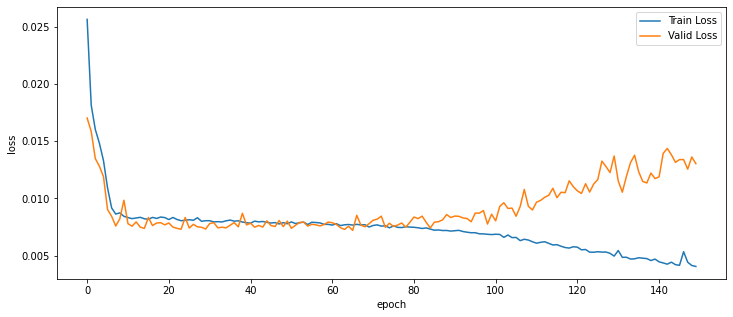

In [29]:
plt.figure(figsize=(12,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.show()

In [30]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
print('Train Score:', trainScore)

testScore = model.evaluate(test_X, test_y, verbose=0)
print('Test Score:', testScore)

Train Score: 0.0038711936213076115
Test Score: 0.013036482036113739


ValueError: ignored

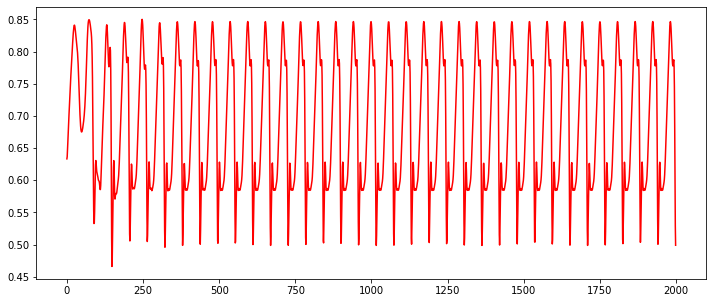

In [32]:
look_ahead = 2000

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=1)
  predictions[i] = prediction
  xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()